In [2]:
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset,DataLoader
import numpy as np
import pandas as pd
import warnings
import time
import seaborn
from torch import nn
from typing import Optional,Union
from torchvision import transforms

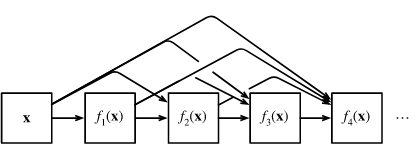<br>
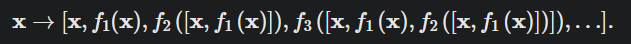

In [5]:
class DenseBlock(nn.Module):
    def __init__(self, out_chinnels:int, n_convs:int=1) -> None:
        super(DenseBlock, self).__init__()
        layers=[]
        # 当逼近的层数为1时与普通ResNet等效,每一层layer等价与上图中的fn(x)
        for i in range(n_convs):
            layers.append(nn.Sequential(
            nn.LazyBatchNorm2d(),nn.ReLU(),
            nn.LazyConv2d(out_chinnels, kernel_size=3, padding=1)
        ))
        self.net = nn.Sequential(*layers)
    
    def forward(self, X:torch.Tensor)->torch.Tensor:
        for blk in self.net:
            Y = blk(X) #fn(x)----------------------->----->fn+1(fn,x)
            #                               ↓       ↑
            X = torch.cat([X, Y], dim=1)# (fn,x)-----
        return X

model = DenseBlock(64,2)
model(torch.rand(2,3,96,96)).shape# (2,(3->64)*2+3,96,96)

torch.Size([2, 131, 96, 96])

In [6]:
# 过渡层(用来控制模型复杂度),此处主要做的处理有:控制输出通道个数,让模型的height,width减半
def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [12]:
class DenseNet():
    def __init__(self,arch:Union[list,tuple], channel_growth_rate:int, out_channels:int, n_classes:int):
        self.net = nn.Sequential(
            nn.Sequential(
                nn.LazyConv2d(out_channels, kernel_size=7, stride=2, padding=3),
                nn.LazyBatchNorm2d(), nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            )
        )
        for i,n_convs in enumerate(arch):
            self.net.add_module(f"denseblk{i+1}",DenseBlock(channel_growth_rate,n_convs))
            # 上一个DenseBlock的输出维度
            out_channels += n_convs * channel_growth_rate
            # 每一个DenseBlock后添加一个过渡层
            if i != len(arch)-1:
                out_channels = out_channels//2
                self.net.add_module(f"transitionblk{i+1}",transition_block(out_channels))
        self.net.add_module('last', nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(n_classes)))
    def forward(self, X):
        return self.net(X)

model = DenseNet(arch=(4,4,4,4),out_channels=64,channel_growth_rate=32,n_classes=10)
model.net(torch.rand(4,5,64,64)).shape #(4,10) 

e:\ProgramData\Anaconda3\envs\pytorchenv\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 10])